# Script IDF

## Librairies

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial

## Données et traitement: Extraction des Maximas par blocs: 

L'extraction des données est la même que pour les autres scripts, mais ici eviter d'utiliser temp=1 car la methode finale est basée sur l'idée d'un processus en minutes

In [28]:
Station = ['Aigle','Dole','Payerne','Fretaz','Pully','Nyon']
num_sta = 5 # Choix de la station
Annees = [['8095','9524'],['8024']]
Temporalité = ['Minutes','Heures']
Temporalité2 = ['10 Minutes', 'Heures']
time_format = ['%M','']
temp = 0 # Choix du type de données (Horaire: 1 ou par 10 minutes: 0)
ratio = [6,1]

if temp == 1:
    raise PermissionError("Choisissez temp=0")

df=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][0]+".txt", sep=";", low_memory=True)

# Si on a les données minutes alors elles sont séparées en plusieurs fichier de 1980 à 2025 et il convient de les fusionner
if Temporalité[temp] == 'Minutes':
    df_temp=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][1]+".txt", sep=";", low_memory=True)

    last_time = df['time'].iloc[-1]
    df_temp_no_overlap= df_temp[df_temp['time'] > last_time]
    df = pd.concat([df, df_temp_no_overlap], ignore_index=True) # Ici on fusionne les données de 80 à 95 avec 95 à 25

del df['stn']
df.time = pd.to_datetime(df['time'], yearfirst=True, utc=False, format='%Y%m%d%H'+time_format[temp])
df.replace('-', 0, inplace=True)
df = df[~df.time.dt.year.isin([2025, 1980])] # J'enlève les années incomplètes manuellement
print(df)

/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_875/1964267701.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][0]+".txt", sep=";", low_memory=True)
/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_875/1964267701.py:17: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp=pd.read_csv("../Database/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][1]+".txt", sep=";", low_memory=True)


                       time rre150z0
7       1981-01-01 00:00:00      0.0
8       1981-01-01 00:10:00      0.0
9       1981-01-01 00:20:00      0.0
10      1981-01-01 00:30:00      0.0
11      1981-01-01 00:40:00      0.0
...                     ...      ...
2314226 2024-12-31 23:10:00      0.0
2314227 2024-12-31 23:20:00      0.0
2314228 2024-12-31 23:30:00      0.0
2314229 2024-12-31 23:40:00      0.0
2314230 2024-12-31 23:50:00      0.0

[2314224 rows x 2 columns]


In [ ]:
N = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
num_years = df['time'].dt.year.nunique()
colonne_valeur = df.columns[1]

maximas = np.zeros(shape=[len(N),num_years])

for i, n in enumerate(N):
    print(f"Calcul des moyennes pour n={n} minutes")
    resultats = []
    groupes = [df.iloc[i:i+n] for i in range(0, len(df), n)]
    for groupe in groupes:
        if len(groupe) == n:  
            annee = groupe['time'].iloc[0].year
            moyenne = pd.to_numeric(groupe[colonne_valeur], errors='coerce').mean()
            resultats.append({'year': annee, f'{colonne_valeur}': moyenne})
    maximas[i] = np.array(pd.DataFrame(resultats).groupby('year')[colonne_valeur].max())

print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta]+'\n\tTemporalité: '+Temporalité2[temp]+f'\n\tAggregation: {n}')

Calcul des moyennes pour n=1 minutes
Calcul des moyennes pour n=2 minutes
Calcul des moyennes pour n=3 minutes
Calcul des moyennes pour n=4 minutes
Calcul des moyennes pour n=5 minutes
Calcul des moyennes pour n=6 minutes
Calcul des moyennes pour n=7 minutes
Calcul des moyennes pour n=8 minutes


# Ajustement des données à la loi de Gumbel:

### Par la méthode des moments

In [ ]:
m1s = np.zeros(len(N))
m2s = np.zeros(len(N))

for i, n in enumerate(N):
    m1s[i] = maximas[i].mean()
    m2s[i] = maximas[i].std(ddof=1)**2  # J'utilise Bessel pour avoir une estimation non biaisée de la variance
    print(f"n={10*n} minutes: mean={m1s[i]}, std={m2s[i]}")

betas = np.sqrt(6*m2s)/np.pi # Il me semble qu'il y a une erreur dans le livre il faut prendre la racine carrée de la variance
alphas = m1s - betas * 0.5772 # 0.5772 est la constante d'Euler-Mascheroni, la formule vient du livre
print('alpha: ', alphas, '\t beta: ', betas) 

n=10 minutes: mean=11.356818181818179, std=34.37134778012685
n=20 minutes: mean=7.828409090909091, std=15.334581131078226
n=30 minutes: mean=6.0227272727272725, std=9.078179469109704
n=40 minutes: mean=4.905681818181819, std=5.812641384778013
n=50 minutes: mean=4.1077272727272724, std=4.239762156448203
n=60 minutes: mean=3.757575757575758, std=3.76857176415316
n=70 minutes: mean=3.2941558441558443, std=2.3790632955084785
n=80 minutes: mean=2.9119318181818183, std=1.6158136231501052
n=90 minutes: mean=2.6969696969696972, std=1.5599102132435467
n=100 minutes: mean=2.519090909090909, std=1.6708456659619444
n=110 minutes: mean=2.284917355371901, std=1.1011837139412577
n=120 minutes: mean=2.2445075757575754, std=1.1055392221634952
alpha:  [8.71835914 6.06607585 4.66675298 3.82065908 3.18106214 2.88391975
 2.60000305 2.33986375 2.13488485 1.93736254 1.81265648 1.77131366] 	 beta:  [4.57113485 3.0532454  2.34922782 1.87980377 1.60544895 1.51361055
 1.20262091 0.99110892 0.97381297 1.00784541 

### Par la méthode de la log-likelihood

In [ ]:
parametres = np.zeros(shape=[len(N),2])

for i, n in enumerate(N):
    parametres[i] = stats.gumbel_r.fit(maximas[i])

alphas, betas = parametres[:,0], parametres[:,1]

print('alpha: ', alphas, '\t beta: ', betas) 

alpha:  [8.86131248 6.1015293  4.69357115 3.86080479 3.23754731 2.96401998
 2.64391869 2.38773695 2.19263775 2.03063354 1.88559261 1.81120819] 	 beta:  [4.10970553 2.86141215 2.16622755 1.68662462 1.37156963 1.27302548
 1.04286519 0.83849932 0.80002735 0.73842825 0.59217598 0.66873841]


# Verification graphique

/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_875/1146672085.py:1: RuntimeWarning: divide by zero encountered in log
  gumbel_index_emp = -np.log(-np.log(np.arange(1, len(maximas[1])+1) / len(maximas[1])))


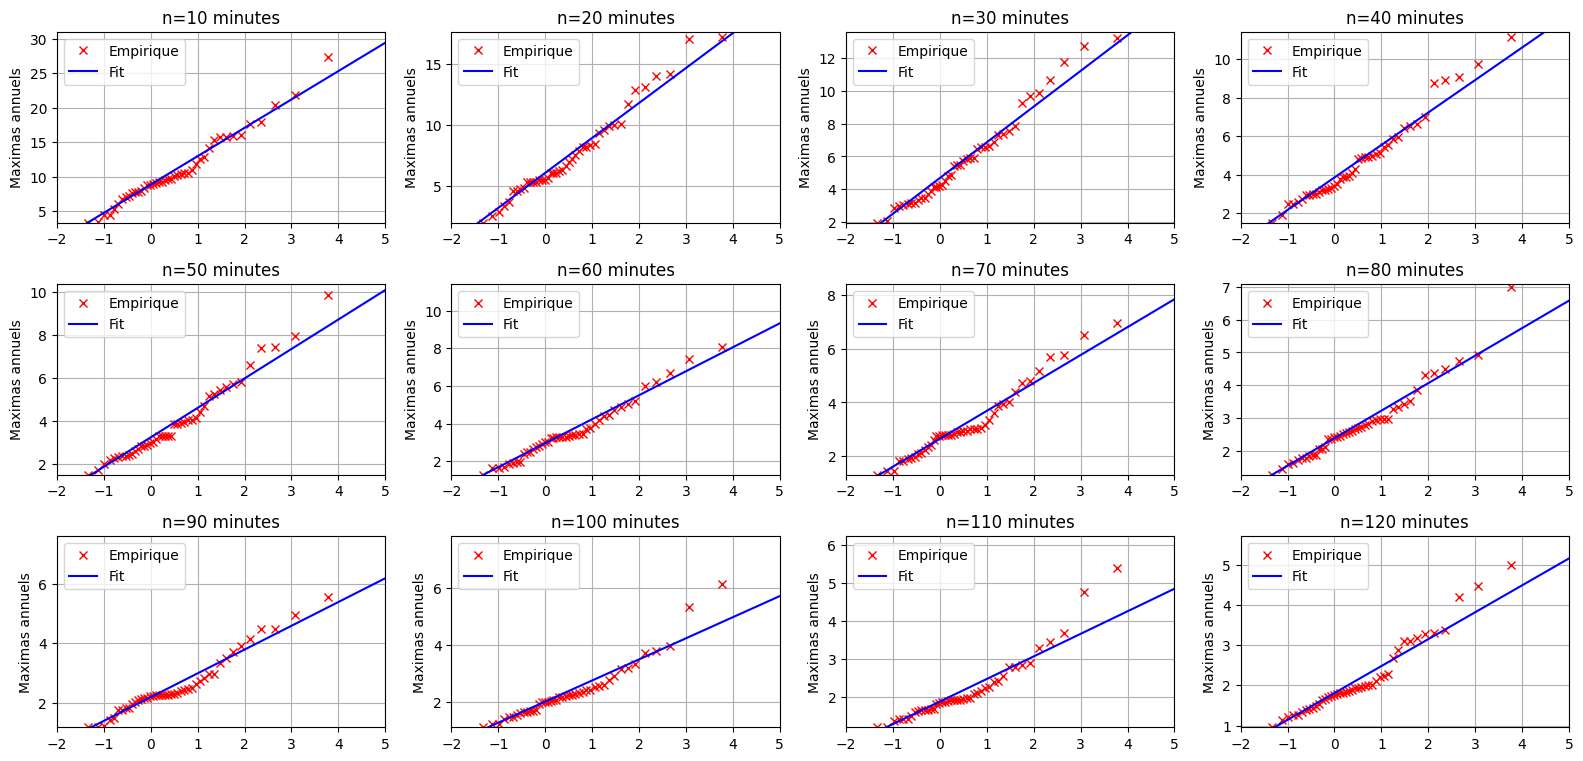

In [ ]:
gumbel_index_emp = -np.log(-np.log(np.arange(1, len(maximas[1])+1) / len(maximas[1])))  
ligne = np.linspace(0,35,10)
gumbel_index_th = (np.tile(ligne, (len(N), 1)) - alphas[:, np.newaxis]) / betas[:, np.newaxis]

plt.figure(figsize=(16, 10))
for i, n in enumerate(N):
    plt.subplot(4, int(len(N)/3), i + 1)
    plt.tight_layout()
    plt.title(f"n={10*n} minutes")
    plt.plot(gumbel_index_emp, np.sort(maximas[i]), 'x', color='red', label='Empirique')
    plt.plot(gumbel_index_th[i], ligne, '-', color='blue', label='Fit')
    plt.legend()
    plt.ylim(np.min(maximas[i]),np.max(maximas[i]))
    plt.xlim(-2, 5)
    plt.ylabel('Maximas annuels')
    plt.grid('on')

# Verification par chi-carré
Avec $\alpha$ = 0.05, Remarque: Avec la méthode des moments pour déterminer $\alpha$ et $\beta$ le chi-carré échoue alors qu'il marche avec la méthode de la maximum likelihood (built-in dans la librairie scipy.stats)(le résultat en soit reste de 0.15 qui est quand-même relativement faible)

In [ ]:
for i,n in enumerate(N):
    classes = np.linspace(np.min(maximas[i]), np.max(maximas[i]), len(maximas[i])//3)
    distribution_obs, _ = np.histogram(maximas[i], bins=classes)
    print('distribution_obs: ', distribution_obs)

    Gumbel_cumulative = np.exp(-np.exp(-(classes - alphas[i]) / betas[i]))
    distribution_th = np.diff(Gumbel_cumulative) * len(maximas[i])
    print('distribution_th: ', distribution_th)

    chi_carre = np.sum((distribution_obs - distribution_th)**2 / distribution_th)
    p_value = 1 - stats.chi2.cdf(chi_carre, len(classes) - 1 - 2) # On a 2 paramètres à estimer (alpha et beta)

    print('chi_carre: ', chi_carre, '\tdegré de liberté: ', len(classes) - 1 - 2, '\tp-value: ',p_value) 

    print('Le fit fonctionne \n' if p_value > 0.05 else 'Le fit ne fonctionne pas \n')

distribution_obs:  [ 5  4 14  6  3  5  3  0  2  0  0  1  1]
distribution_th:  [3.47490504 6.7655535  8.28022791 7.61354251 5.88361282 4.0944886
 2.67586651 1.68426035 1.03660113 0.62951259 0.379258   0.22740623
 0.13596946]
chi_carre:  19.44944164504849 	degré de liberté:  11 	p-value:  0.0534877847925852
Le fit fonctionne 

distribution_obs:  [ 3  2 11  7  4  4  5  0  1  3  1  0  3]
distribution_th:  [2.14001386 4.41410893 6.21032517 6.75688221 6.19348498 5.06692238
 3.84515556 2.77689177 1.9410232  1.32794202 0.89577393 0.5986738
 0.39768237]
chi_carre:  29.695051316298155 	degré de liberté:  11 	p-value:  0.0017689614950572308
Le fit ne fonctionne pas 

distribution_obs:  [ 2 10  6  5  4  6  3  0  3  1  1  0  3]
distribution_th:  [2.96994213 5.11555942 6.42705065 6.52610752 5.74472874 4.59680305
 3.45182771 2.48484079 1.73927495 1.19497121 0.8109399  0.54584384
 0.36542197]
chi_carre:  29.398050869405118 	degré de liberté:  11 	p-value:  0.0019683722626233635
Le fit ne fonctionne pa

# Contrôle des incertitudes:
D'après la formule du livre

In [ ]:
def std_quantile(gumbel_index,i):
    return betas[i]/np.sqrt(len(maximas[i]))*(np.sqrt(1.1086 + 0.514*gumbel_index + 0.697*gumbel_index**2))

# Plots

### Courbes à durées fixes

/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_875/3380875252.py:6: RuntimeWarning: divide by zero encountered in divide
  Temps_retour = 1/(1 - np.exp(-np.exp(-(np.linspace(0,50,50) - alphas[i]) / betas[i])))


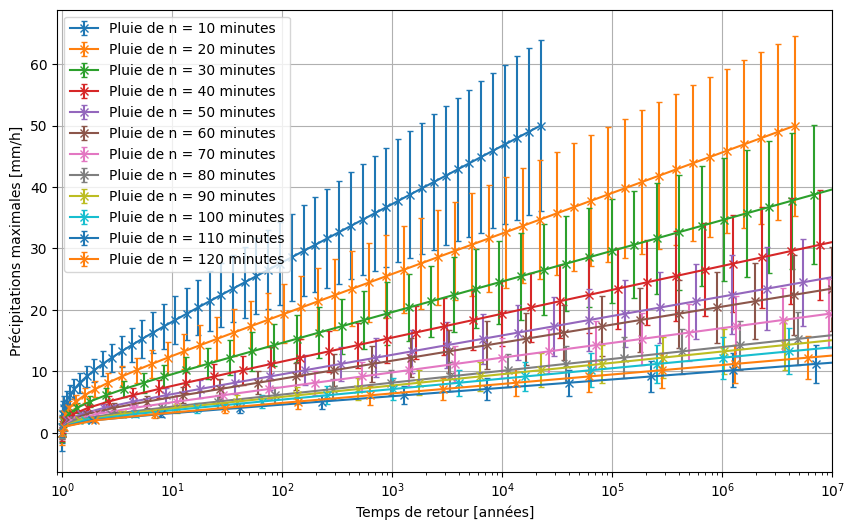

In [ ]:
z = 1.29 # Pour un intervalle de confiance de 80%, z=1.29

plt.figure(figsize=(10, 6))
plt.subplot()
for i, n in enumerate(N):
    Temps_retour = 1/(1 - np.exp(-np.exp(-(np.linspace(0,50,50) - alphas[i]) / betas[i])))
    plt.errorbar(Temps_retour, np.linspace(0,50,50), yerr=2*z*std_quantile((np.linspace(0,50,50)-alphas[i])/betas[i],i), fmt='-x', label=f'Pluie de n = {10*n} minutes', capsize=2)
    plt.xlabel('Temps de retour [années]')
    plt.ylabel('Précipitations maximales [mm/h]')
    plt.xlim(0.9,10000000)
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

### Courbes IDF

#### Fit des paramètres Montana, c'est pour des pluies horaires. Si pluies 10 minutes, il faut faire Talbot et Montana

In [ ]:
T = np.array([2,5,10,20,50,100])

montana_param = np.zeros(shape=[len(T),2])

gumbel_index_ = -np.log(-np.log((T-1)/T))
Frequencies = np.einsum('j,i->ij',gumbel_index_,betas) + alphas[:, np.newaxis]

lna = np.zeros(len(T))
b = np.zeros(len(T))
berr = np.zeros(len(T))
lnaerr = np.zeros(len(T))

for j, _ in enumerate(T):
    result = stats.linregress(np.log(N), np.log(Frequencies[:,j]))
    b[j] = result.slope
    lna[j] = result.intercept
    berr[j] = result.stderr
    lnaerr[j] = result.intercept_stderr

montana_param[:,0] = np.exp(lna)
montana_param[:,1] = -b

print('Montana parameters: ', montana_param)

Montana parameters:  [[11.0721585   0.67476737]
 [16.42228452  0.71067452]
 [19.97789844  0.72497336]
 [23.39399218  0.73499268]
 [27.82086049  0.74461081]
 [31.14073834  0.75016226]]


#### Montana curves

/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_875/3879631019.py:6: RuntimeWarning: divide by zero encountered in power
  p1, = plt.plot(np.arange(0,200), montana_param[j,0]*(np.arange(0,200)**(-montana_param[j,1])), '-', label=f'Pluie de temps de retour = {t} années')


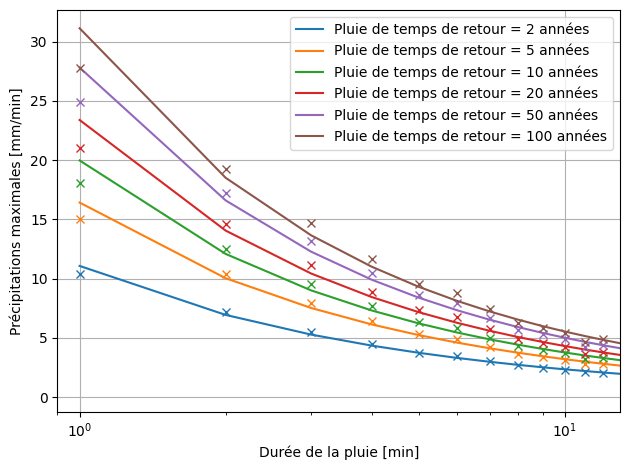

In [ ]:
Frequencies_error = 2*z*std_quantile(gumbel_index_,np.arange(len(T)))

plt.figure()
plt.subplot()
for j, t in enumerate(T):
    p1, = plt.plot(np.arange(0,200), montana_param[j,0]*(np.arange(0,200)**(-montana_param[j,1])), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    plt.plot(N, Frequencies[:,j],'x', color=color)
plt.xlabel('Durée de la pluie [min]')
plt.ylabel('Précipitations maximales [mm/min]')
plt.xscale('log')
plt.xlim(0.9,13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Fit des courbes Talbot - Montana pour des pluies minutes: Spoiler le pivot ne converge pas

In [24]:
T = np.array([2,5,10,20,50,100])

montana_param = np.zeros(shape=[len(T),2])
talbot_param = np.zeros(shape=[len(T),2])

dpivot_ini = 3

a = montana_param[:,0]
b = montana_param[:,1]

gumbel_index_ = -np.log(-np.log((T-1)/T))
Frequencies = np.einsum('j,i->ij',gumbel_index_,betas) + alphas[:, np.newaxis]

def talbot_function(N, dpivot, a, b):
    return ((a/b)*dpivot**(1-b))/(dpivot/b-dpivot+N)

def montana_function(N, a, b):
    return a * N**(-b)

def residuals(dpivot, N, y, a, b, reg_lambda=0.1):
    model = talbot_function(N, dpivot, a, b)
    res = model - y
    reg = reg_lambda*dpivot
    return np.append(res, reg)

dpivots = dpivot_ini*np.ones(len(T))
lna = np.zeros(len(T))
bminus = np.zeros(len(T))
Nsup_final = np.zeros(shape=[len(T), len(N)])
Ninf_final = np.zeros(shape=[len(T), len(N)])

for j, t in enumerate(T):
    print(f'Temps de retour = {t} ans')
    while True:
        Nsup = N[N > dpivots[j]]
        Frequenciessup = Frequencies[N > dpivots[j], :]
        Ninf = N[N <= dpivots[j]]
        Frequenciesinf = Frequencies[N <= dpivots[j], :]

        result = stats.linregress(np.log(Nsup), np.log(Frequenciessup[:,j]))
        bminus[j] = result.slope
        lna[j] = result.intercept

        a[j] = np.exp(lna[j])
        b[j] = -bminus[j]

        fit_talbot = partial(talbot_function, a=a[j], b=b[j])
        result = scipy.optimize.least_squares(residuals, x0=[dpivots[j]], args=(Ninf, Frequenciesinf[:,j], a[j], b[j], 0))
        dpivots[j] = result.x[0]
        print(dpivots[j])

        if len(N[N>dpivots[j]]) == len(Nsup):
            break

print('Pivot point: ', dpivots)

montana_param[:,0] = a
montana_param[:,1] = b


talbot_param[:,0] = (a/b)*(dpivots**(1-b))
talbot_param[:,1] = dpivots*(1/b - 1)

print('Montana parameters: ', montana_param)
print('Talbot parameters: ', talbot_param)

Temps de retour = 2 ans
3.3975738029184237
Temps de retour = 5 ans
4.545401489601038
4.816248841180344
Temps de retour = 10 ans
5.135291865633682
7.614555708005779
2.3937096411430248
4.809848009292162
5.545911518985137
7.614555521839121
2.3937094938636037
4.809848008108239
5.545911520192561
7.614555520904681
2.3937094962767422
4.809848008108242
5.545911519435464
7.614555520904682
2.393709557534717
4.8098480085694195
5.545911519588851
7.614555519962803
2.393709467917542
4.809848008108243
5.545911519084902
7.6145555150370825
2.393709601277617
4.809848009653534
5.545911519266931
7.614555523644657
2.3937095337314864
4.8098480096535345
5.545911519829516
7.614555518438097
2.3937094753589814
4.809848008108242
5.545911519435464
7.614555520904682
2.393709557534717
4.8098480085694195
5.545911519588851
7.614555519962803
2.393709467917542
4.809848008108243
5.545911519084902
7.6145555150370825
2.393709601277617
4.809848009653534
5.545911519266931
7.614555523644657
2.3937095337314864
4.8098480096535

KeyboardInterrupt: 

## Méthode numéro 2

In [ ]:
def montana_complexe(a,b,n,N):
    return a/((N+b)**n)

def residuals_2(params, N, Frequencies):
    a = params[0]
    b = params[1]
    n = params[2]
    model = montana_complexe(a,b,n,N)
    residual = model - Frequencies
    return residual

In [ ]:
import scipy.optimize


T = np.array([2,5,10,20,50,100])
a = np.zeros(len(T))
b = np.zeros(len(T))
n = np.zeros(len(T))
gumbel_index_ = -np.log(-np.log((T-1)/T))
Frequencies = np.einsum('j,i->ij',gumbel_index_,betas) + alphas[:, np.newaxis]

for i, t in enumerate(T):
    result = scipy.optimize.least_squares(residuals_2, x0=[a[i],b[i],n[i]], args=(N, Frequencies[:,i]))
    a[i] = result.x[0]
    b[i] = result.x[1]
    n[i] = result.x[2]
    print(f'a = {a[i]}, \t b = {b[i]} \t n = {n[i]} \n')

a = 16.03937951872663, 	 b = 0.6995693486078717 	 n = 0.820471955930975 

a = 28.383839292220035, 	 b = 0.9907022751234916 	 n = 0.9222170143476492 

a = 37.384511149814614, 	 b = 1.1158544480647703 	 n = 0.9656543191385457 

a = 46.439490174160255, 	 b = 1.2068880387025764 	 n = 0.9971540842311863 

a = 58.60820945795993, 	 b = 1.2969641033204802 	 n = 1.028250244799826 

a = 67.97684901414878, 	 b = 1.3501876550723935 	 n = 1.0465926105227894 



/var/folders/zg/4t8nx6t5013gpmtrh9sl39zc0000gn/T/ipykernel_875/2600931176.py:2: RuntimeWarning: invalid value encountered in power
  return a/((N+b)**n)


### Plot de la deuxième méthode

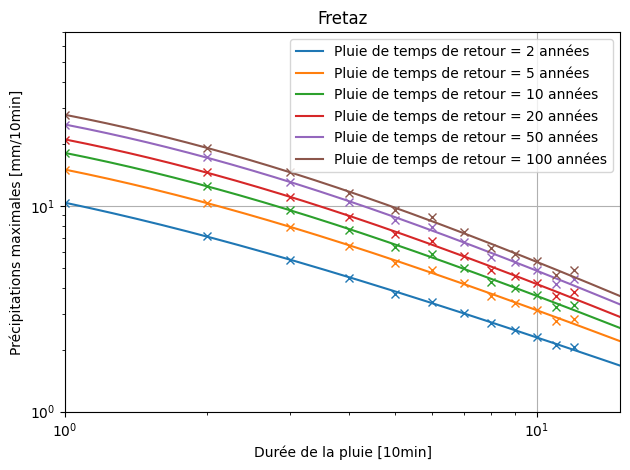

In [ ]:
plt.figure()
plt.subplot()
for j, t in enumerate(T):
    p1, = plt.plot(np.linspace(1,15,1000), montana_complexe(a[j],b[j],n[j],np.linspace(1,15,1000)), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    plt.plot(N, Frequencies[:,j],'x',color=color)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.title(Station[num_sta])
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,15)
plt.ylim(1, 70)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot de la première méthode

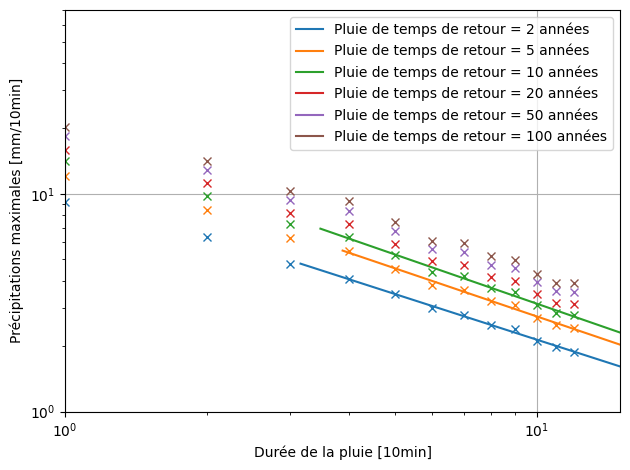

In [ ]:
plt.figure()
plt.subplot()
for j, t in enumerate(T):
    p1, = plt.plot(np.linspace(dpivots[j],200), montana_param[j,0]*(np.linspace(dpivots[j],200)**(-montana_param[j,1])), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    p2, = plt.plot(np.linspace(1,dpivots[j],100), talbot_param[j,0]/(np.linspace(1,dpivots[j],100)+talbot_param[j,1]), '-', color=color)
    plt.plot(N, Frequencies[:,j],'x',color=color)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,15)
plt.ylim(1, 70)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()